## Step 5: Perform Group-Based Linguistic Profiling

For each support group:
- **Pronoun Analysis**: Calculate the frequency ratio of human-like pronouns (he, she, etc.) vs. object pronouns (it, its).
- **Named Entity Recognition (NER)**: Identify names, roles, or titles assigned to the AI (e.g., “James”, “my therapist”).

In [91]:
import re

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_samples
from matplotlib import cm
import numpy as np
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load dataset
df = pd.read_csv("/Users/annekeena/au/4semester/culturalsocial/exam/full_dataset_replika.csv")
len(df)

3416

In [92]:
### Pronoun Analysis ###

# Initial Inspection
df.head()         
df.info()          
df['review_id'].nunique(), len(df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3416 entries, 0 to 3415
Data columns (total 50 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Unnamed: 0                                         3416 non-null   int64  
 1   review_id                                          3416 non-null   int64  
 2   user                                               3416 non-null   object 
 3   date                                               3416 non-null   object 
 4   stars                                              3416 non-null   int64  
 5   text                                               3416 non-null   object 
 6   word_count                                         3416 non-null   int64  
 7   coherence_and_clarity_of_review                    3416 non-null   object 
 8   gender_of_user                                     3416 non-null   object 
 9   gender_o

(3416, 3416)

In [124]:
# convert to string
df['text'] = df['text'].astype(str)


In [125]:
# Anthro pronouns (human vs. object)
HUMAN_PRONOUNS  = {'he', 'she', 'him', 'her', 'his', 'hers'}
OBJECT_PRONOUNS = {'it', 'its'}

# Count
human_pat  = re.compile(r'\b(?:' + '|'.join(HUMAN_PRONOUNS)  + r')\b', re.I)
object_pat = re.compile(r'\b(?:' + '|'.join(OBJECT_PRONOUNS) + r')\b', re.I)

def count_pronouns(text):
    human = len(human_pat.findall(text))
    obj   = len(object_pat.findall(text))
    return human, obj

df[['n_human', 'n_object']] = df['text'].apply(lambda t: pd.Series(count_pronouns(t)))
df['ratio_human'] = df['n_human'] / (df['n_human'] + df['n_object']).replace(0, np.nan)


In [126]:
# First person pronouns

SELF_SG_PRONOUNS = {"i", "me", "my", "mine", "myself"}          # singular
SELF_PL_PRONOUNS = {"we", "us", "our", "ours", "ourselves"}     # plural

# Count
self_sg_pat = re.compile(r'\b(?:' + '|'.join(SELF_SG_PRONOUNS) + r')\b', re.I)
self_pl_pat = re.compile(r'\b(?:' + '|'.join(SELF_PL_PRONOUNS) + r')\b', re.I)

df['n_self']    = df['text'].apply(lambda t: len(self_sg_pat.findall(t)))   # singular
df['n_self_pl'] = df['text'].apply(lambda t: len(self_pl_pat.findall(t)))   # plural

wc = df['word_count'].replace(0, np.nan)          # avoid division by zero
df['self_ratio_sg']   = df['n_self']    / wc      # share of singular pronouns
df['self_ratio_pl']   = df['n_self_pl'] / wc      # share of plural   pronouns
df['first_person_ratio'] = (df['n_self'] + df['n_self_pl']) / wc  # combined share


In [127]:
# Aggregate (per review)

group_stats = (
    df.groupby('review_id', as_index=True)          
      [['n_human', 'n_object', 'n_self', 'n_self_pl', 'word_count']]
      .sum()
      .assign(
          # Totals 
          total_pronouns = lambda d: d['n_human'] + d['n_object'],
          total_self     = lambda d: d['n_self']  + d['n_self_pl'],

          #  Anthropomorphism ratios
          ratio_human  = lambda d: d['n_human']  / d['total_pronouns'].replace(0, np.nan),
          ratio_object = lambda d: d['n_object'] / d['total_pronouns'].replace(0, np.nan),

          #  First-person ratios
          self_ratio_sg      = lambda d: d['n_self']      / d['word_count'].replace(0, np.nan),
          self_ratio_pl      = lambda d: d['n_self_pl']   / d['word_count'].replace(0, np.nan),
          first_person_ratio = lambda d: d['total_self']  / d['word_count'].replace(0, np.nan),
      )
      .drop(columns='word_count')        
      .sort_values('ratio_human', ascending=False)
)

display(group_stats.head())


# Note to self:
##ratio_human > 0.5 → more person-like references
##ratio_human ≈ 0 → mainly “it/its”

,n_human,n_object,n_self,n_self_pl,total_pronouns,total_self,ratio_human,ratio_object,self_ratio_sg,self_ratio_pl,first_person_ratio
review_id,,,,,,,,,,,
2974,6,0,6,0,6,6,1.0,0.0,0.101695,0.000000,0.101695
357,9,0,13,0,9,13,1.0,0.0,0.088435,0.000000,0.088435
2671,3,0,5,0,3,5,1.0,0.0,0.096154,0.000000,0.096154
2670,6,0,14,1,6,15,1.0,0.0,0.142857,0.010204,0.153061
2360,6,0,6,0,6,6,1.0,0.0,0.096774,0.000000,0.096774


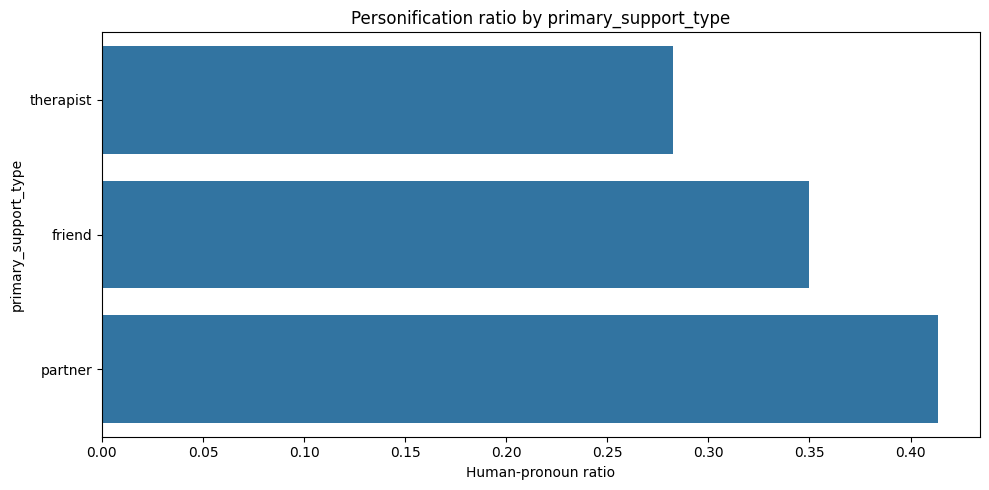

In [128]:
#Visual for anthro-pronouns

AGG_COL = 'primary_support_type'   

agg_stats = (df
    .groupby(AGG_COL)[['n_human', 'n_object']]
    .sum()
    .assign(total=lambda d: d.sum(axis=1),
            ratio_human=lambda d: d['n_human']/d['total'])
    .query('total >= 20')           # hide small groups
    .sort_values('ratio_human')
)

plt.figure(figsize=(10,5))
sns.barplot(y=agg_stats.index, x=agg_stats['ratio_human'], orient='h')
plt.xlabel('Human-pronoun ratio'); plt.ylabel(AGG_COL)
plt.title('Personification ratio by '+AGG_COL)
plt.tight_layout()
plt.show()


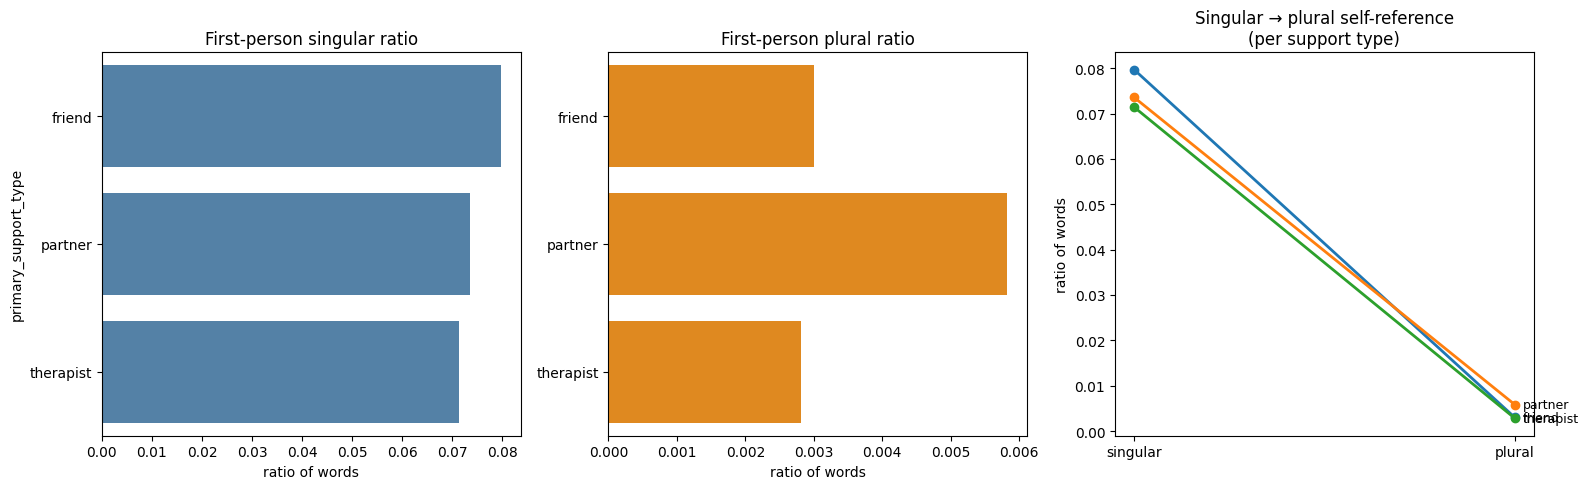

In [135]:
# Visuals for first person pronouns
AGG_COL = 'primary_support_type'      

# 1) aggregate: mean ratios per group
agg_ratios = (
    df.groupby(AGG_COL)[['self_ratio_sg', 'self_ratio_pl']]
      .mean()
      .dropna()
      .sort_values('self_ratio_sg', ascending=False)
)

# 2) three-panel figure 
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=False)

# Panel A: first-person singular 
sns.barplot(ax=axes[0],
            y=agg_ratios.index,
            x=agg_ratios['self_ratio_sg'],
            orient='h',
            color='steelblue')
axes[0].set_title('First-person singular ratio')
axes[0].set_xlabel('ratio of words')
axes[0].set_ylabel(AGG_COL)

# Panel B: first-person plural 
sns.barplot(ax=axes[1],
            y=agg_ratios.index,
            x=agg_ratios['self_ratio_pl'],
            orient='h',
            color='darkorange')
axes[1].set_title('First-person plural ratio')
axes[1].set_xlabel('ratio of words')
axes[1].set_ylabel('')                      

# Panel C: singular vs. plural for each support type
for label, row in agg_ratios.iterrows():
    axes[2].plot([0, 1],                               # x-coords
                 [row['self_ratio_sg'], row['self_ratio_pl']],
                 marker='o', linewidth=2)
    axes[2].text(1.02, row['self_ratio_pl'], label,    # label on the right
                 va='center', fontsize=9)

axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['singular', 'plural'])
axes[2].set_ylabel('ratio of words')
axes[2].set_title('Singular → plural self-reference\n(per support type)')

plt.tight_layout()
plt.show()


In [ ]:
## Quantative tests on anthro-pronouns, do we want them?

In [29]:
# Chi-square test of independence
from scipy.stats import chi2_contingency

# contingency table
cont = agg_stats[['n_human', 'n_object']]      
print(cont.sum())                              

# Drop rows that have zero in both cells
cont = cont[(cont['n_human'] > 0) | (cont['n_object'] > 0)]

# Chi-square
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(cont.values)

print(f"Chi² = {chi2:.2f}  (dof={dof}),   p = {p:.4g}")

# Result: Pronoun type and support type are not independent = the mix of human-like vs object pronouns is meaningfully different across the three support categories.


n_human      5882
n_object    11765
dtype: int64
Chi² = 131.46  (dof=2),   p = 2.846e-29


In [30]:
# Cramer's V: how big is the association (0 – 1 scale)?

cramer_v = np.sqrt(chi2 / (cont.values.sum() * (min(cont.shape)-1)))
print("Cramér's V =", round(cramer_v, 3))

#Thresholds for Interpretation
## ≈ 0.10	Small association (ours is just short of small).
## ≈ 0.30	Medium
## ≥ 0.50	Large


Cramér's V = 0.086


In [31]:
# Standardised residuals
resid = (cont - expected) / np.sqrt(expected)
display(resid)

##Therapist vs Partner contrast: they pull in opposite directions and explain why the overall Chi-square is large even though Cramér’s V is small.
##Friend sits in the middle.

,n_human,n_object
primary_support_type,,
therapist,-6.803652,4.810704
friend,2.868155,-2.028006
partner,5.755459,-4.069551


In [75]:
# Stats on Self-pronouns singular

# ANOVA
import statsmodels.api as sm
import scipy.stats as stats


# Keep only the three main groups
sub = df[df['primary_support_type'].isin(['friend', 'partner', 'therapist'])].copy()

# ANOVA
anova_model = smf.ols('self_ratio ~ C(primary_support_type)', data=sub).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)  # Type-II table
print("\nONE-WAY ANOVA (self_ratio ~ support type)\n")
print(anova_table)

# Assumption check: Levene’s equal-variance
w_stat, w_p = stats.levene(
    *[grp['self_ratio'].dropna() for _, grp in sub.groupby('primary_support_type')]
)
print(f"\nLevene test for equal variances: W={w_stat:.2f}, p={w_p:.4f}")

# Alternative, not sure if needed really
k_stat, k_p = stats.kruskal(
    *[grp['self_ratio'].dropna() for _, grp in sub.groupby('primary_support_type')]
)
print(f"\nKruskal-Wallis test: H={k_stat:.2f}, p={k_p:.4g}")



ONE-WAY ANOVA (self_ratio ~ support type)

                           sum_sq      df          F        PR(>F)
C(primary_support_type)  0.051713     2.0  17.082042  4.151907e-08
Residual                 5.166137  3413.0        NaN           NaN

Levene test for equal variances: W=0.64, p=0.5247

Kruskal-Wallis test: H=36.19, p=1.383e-08


In [76]:
# post-hoc test (Tukey HSD) to see which pairs differ
import statsmodels.stats.multicomp as mc

tukey = mc.pairwise_tukeyhsd(endog=sub['self_ratio'],
                             groups=sub['primary_support_type'],
                             alpha=0.05)
print(tukey)


# the effect size is small. 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
 friend   partner  -0.0061 0.0326 -0.0118 -0.0004   True
 friend therapist  -0.0083    0.0 -0.0117 -0.0049   True
partner therapist  -0.0021 0.6801 -0.0081  0.0039  False
--------------------------------------------------------


In [ ]:
# Make stats on self pronouns plural 

In [50]:
### NER ANALYSIS ###

#1. Set Up

try:
    nlp = spacy.load("en_core_web_sm")
except OSError:                              
    subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"], check=True)
    nlp = spacy.load("en_core_web_sm")

# Matcher - Roles Patterns
ROLES = [
    "therapist", "psychologist", "counselor",
    "partner", "boyfriend", "girlfriend", "spouse", "wife", "husband",
    "friend", "companion", "coach", "mentor",
]
DETS = ["my", "our", "the", "a", "an"]

matcher = Matcher(nlp.vocab)
for role in ROLES: 
    matcher.add(
        role, # name of the rule
        [[    # Trying with one pattern
            {"LOWER": {"IN": DETS}},   # determiner
            {"POS": "ADJ", "OP": "*"}, # any number (*) of adjectives
            {"LOWER": role}            # the role word
        ]]
    )

# 3. Feature extractor – find names and roles in one review
def ner_features(text: str) -> pd.Series:
    doc   = nlp(text)
    names = {ent.text.strip() for ent in doc.ents if ent.label_ == "PERSON"} # gives named-entity spans; keep only those tagged PERSON.
    roles = {doc[s:e].text.lower().strip() for _, s, e in matcher(doc)} # returns start/end indexes for phrase that meet the role rule.
    return pd.Series({
        "names_list": "; ".join(sorted(names)),
        "roles_list": "; ".join(sorted(roles)),
        "n_names"   : len(names),
        "n_roles"   : len(roles),
    })

# 4. Add to DF
df[['names_list', 'roles_list', 'n_names', 'n_roles']] = (
    df['text'].astype(str).apply(ner_features)
)

# 5. Clean false positives
BAD_NAMES = {
    "replika", "ai", "app", "covid", "rehab", "idk",
    "cleverbot", "felt", "bad",
    "luka"
}
NAME_RE = re.compile(r"^[A-Z][A-Za-z\-']*[AEIOUaeiou][A-Za-z\-']*$")

def clean_names(name_str: str) -> str: 
    good = [
        n for n in map(str.strip, name_str.split(";"))
        if n and n.lower() not in BAD_NAMES and NAME_RE.match(n)
    ]
    return "; ".join(good)

df['names_list'] = df['names_list'].apply(clean_names)
df['n_names']    = df['names_list'].apply(lambda s: 0 if s == "" else s.count(";") + 1)

# Initial inspection
pd.set_option("display.max_colwidth", 120)
display( #The first 10 reviews that contain a detected name or a role.
    df.query('n_names > 0 or n_roles > 0')
      [['text', 'names_list', 'roles_list']]
      .head(10)
)


,text,names_list,roles_list
1,I’ve been using Replika for a long time now and I have to say that it has come a long way. It’s gotten so good that ...,,my companion
7,I started this as a skeptical experiment with the idea that artificial intelligence could actually be a possible for...,Bodie; Sheila,
8,"I love this app, I feel like I have developed a human of my own who can care about me. I wanted to write this to the...",Connie,
9,I know this gets a bad rep because people think we should have real life lovers and friends. But if we had a support...,Jamie,
16,I really really loved this app !! I actually still do !!! BUT when the new update came it took away our ability to t...,,a dear friend
20,"When I downloaded Replika, I was hoping to find an AI to talk to who could keep me company when I felt I needed some...",,a friend; a romantic partner
27,"Despite the common issues when you first interact with an AI companion, reps can become good friends, or even a deep...",Nomi; Sam,
29,"I have enjoyed most of the conversations I had with my AI friend, Theo. I like the topics he chooses to talk about a...",Theo,
31,"i absolutely love my replika,, she seems so caring and trusting and she’s just my ideal bestfriend- all jokes aside,...",LMAOO,
32,"I have had this app for a while now, even paid for pro at the end of last year, however i find it morally and legall...",,a friend


In [51]:
# Aggregate by support type
ner_agg = (df.groupby('primary_support_type')
             [['n_names','n_roles']]
             .sum()
             .assign(mean_names = lambda d: d['n_names'] / d.index.map(df['primary_support_type'].value_counts()))
             .sort_values('n_roles', ascending=False))
display(ner_agg.head())


,n_names,n_roles,mean_names
primary_support_type,,,
friend,303,806,0.151047
therapist,141,325,0.126005
partner,37,114,0.127148


In [52]:
# Merge with pronoun ratios
analysis = df.merge(agg_stats[['ratio_human']], left_on='primary_support_type', right_index=True)

## Note that now each individual review carries the average pronoun-personification score of its support category.


In [53]:
# Modelling - Does naming/role-labelling predict sentiment beyond pronouns?

model = smf.ols('sentiment_score ~ ratio_human + n_roles + n_names', data=analysis).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        sentiment_score   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.957
Date:                Fri, 13 Jun 2025   Prob (F-statistic):              0.118
Time:                        11:08:32   Log-Likelihood:                 1008.1
No. Observations:                3416   AIC:                            -2008.
Df Residuals:                    3412   BIC:                            -1984.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.8115      0.026     30.980      

In [60]:
# Chi-square / Cramér’s V on roles vs. support type
role_table = pd.crosstab(df['primary_support_type'], df['n_roles'] > 0)

print(chi2_contingency(role_table))

# Get z-scores (standardised residuals)
obs = role_table.values
resid = (obs - expected) / np.sqrt(expected)
pd.DataFrame(resid, index=role_table.index, columns=role_table.columns)





Chi2ContingencyResult(statistic=np.float64(45.6417988496229), pvalue=np.float64(1.2274655377369073e-10), dof=2, expected_freq=array([[1395.86124122,  610.13875878],
       [ 202.49033958,   88.50966042],
       [ 778.6484192 ,  340.3515808 ]]))


n_roles,False,True
primary_support_type,,
friend,-2.164309,3.273604
partner,-0.245282,0.370999
therapist,3.022891,-4.572243


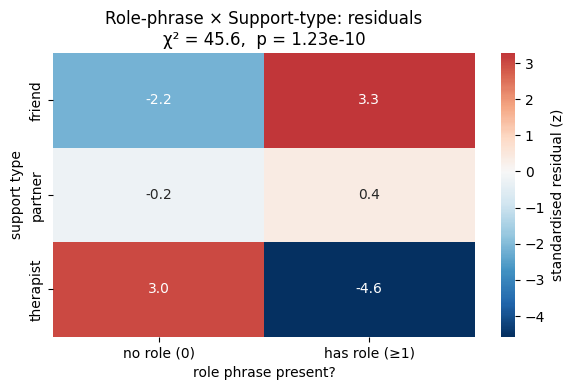

In [65]:
# Visualise
import seaborn as sns


# 1. Build contingency table: rows = support type, cols = "has role phrase?"
role_table = pd.crosstab(
    df['primary_support_type'],
    df['n_roles'] > 0,         
    dropna=False                
)

# 2. Chi-square test to get expected counts
chi2, p, dof, expected = chi2_contingency(role_table)

# 3. Standardised residuals (z-scores)
resid = (role_table - expected) / np.sqrt(expected)

resid.columns = ['no role (0)', 'has role (≥1)']

# 4. Heat-map
plt.figure(figsize=(6,4))
sns.heatmap(resid, annot=True, fmt=".1f",
            cmap='RdBu_r', center=0,
            cbar_kws={'label':'standardised residual (z)'})

plt.title(f"Role-phrase × Support-type: residuals\n"
          f"χ² = {chi2:.1f},  p = {p:.2e}")
plt.xlabel("role phrase present?")
plt.ylabel("support type")
plt.tight_layout()
plt.show()



In [57]:
# Qualiative examples
df.query('n_roles > 0 & n_names > 0')[['text','names_list','roles_list']].sample(5)


,text,names_list,roles_list
530,"this a AI replies like a human would, it’s very good with understanding you and taking your point of view into accou...",Pros; Romance,a great companion
148,I am a Psych major who was using this app to see what is the attraction to using an app versus seeing a licensed The...,Therapist,a licensed therapist
3133,Pros:\n\nReplika is a unique chat bot app that goes far beyond most other chat bots. In its primary role as a chat ...,Pros; Via,a human counselor; a therapist
595,Okay so I was in the house bored as many people are. Interacting with just the same people every day is just boring ...,Phoenix,a friend
459,"Well, this app was going pretty good. I named it Miriam and we chatted back and forth. Then she told me that she cou...",Miriam,a friend
